# Combine Hustle + Box Score Stats

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd())) 

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

from src.constants import HEADERS

pd.set_option('display.max_columns', None)

In [2]:
DATA_DIR = '../data/'
lgl_path = os.path.join(DATA_DIR, 'df_logs.csv')
hustle_files = [f for f in os.listdir('../data') if f.startswith('df_hustle')]
hustle_paths = [os.path.join(DATA_DIR, f) for f in hustle_files]

In [3]:
# Read in Data
df_logs = pd.read_csv(lgl_path)
df_hustle_list = [pd.read_csv(f) for f in hustle_paths]
df_hustle = pd.concat(df_hustle_list)

In [4]:
df_logs.shape, df_hustle.shape

((7380, 29), (1150, 22))

In [119]:
df_logs.head(6)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22022,1610612738,BOS,Boston Celtics,22200001,2022-10-18,BOS vs. PHI,W,240,46,82,0.561,12,35,0.343,22,28,0.786,6,30,36,24,8,3,11,24,126,9,1
1,22022,1610612755,PHI,Philadelphia 76ers,22200001,2022-10-18,PHI @ BOS,L,240,40,80,0.500,13,34,0.382,24,28,0.857,4,27,31,16,8,3,14,25,117,-9,1
2,22022,1610612744,GSW,Golden State Warriors,22200002,2022-10-18,GSW vs. LAL,W,240,45,99,0.455,16,45,0.356,17,23,0.739,11,37,48,31,11,4,18,23,123,14,1
3,22022,1610612747,LAL,Los Angeles Lakers,22200002,2022-10-18,LAL @ GSW,L,240,40,94,0.426,10,40,0.250,19,25,0.760,9,39,48,23,12,4,22,18,109,-14,1
4,22022,1610612759,SAS,San Antonio Spurs,22200011,2022-10-19,SAS vs. CHA,L,240,40,99,0.404,7,34,0.206,15,21,0.714,14,30,44,22,8,8,15,19,102,-27,1
5,22022,1610612743,DEN,Denver Nuggets,22200012,2022-10-19,DEN @ UTA,L,240,40,83,0.482,5,22,0.227,17,18,0.944,10,25,35,21,10,3,21,23,102,-21,1


In [202]:
def process_logs(df: pd.DataFrame, neutral_dict: dict) -> pd.DataFrame:
    # Add home team indicator
    df['HOME_IND'] = np.where(df['MATCHUP'].str.contains('@'),'AWAY','HOME')

    # Handle handful of international games manually --> figure out more robust solution later...
    neutral_games_idx = []
    for game_id, home_team in neutral_dict.items():
        neutral_games_idx.append(df[(df['GAME_ID']==game_id) & (df['TEAM_ABBREVIATION']==home_team)].index.values[0])
    df.loc[neutral_games_idx, 'HOME_IND'] = 'HOME'
    
    
    # Define columns
    team_cols = ['TEAM_ID','TEAM_ABBREVIATION','TEAM_NAME','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','AST','STL','BLK','TOV','PF','PTS']
    non_team_cols = ['SEASON_ID','GAME_ID','GAME_DATE']

    # Pivot data (convert 2 rows per game to 1 row per game)
    df_pivoted = df.set_index(non_team_cols+['HOME_IND'])[team_cols].unstack('HOME_IND')

    # Flatten column names
    df_pivoted.columns = [f"{home_ind}_{col}" for col, home_ind in df_pivoted.columns]
    df_result = df_pivoted.reset_index()
    
    # Add neutral indicator column
    df_result['NEUTRAL_IND'] = 0
    df_result.loc[df_result['GAME_ID'].isin(list(neutral_dict.keys())), 'NEUTRAL_IND'] = 1

    return df_result

In [203]:
neutral_game_ids = [22400147, 22401230, 22401229, 22400621, 22400633]
neutral_home_teams = ['WAS','OKC','ATL','IND','SAS']
neutral_dict = dict(zip(neutral_game_ids,neutral_home_teams))
d_proc = process_logs(df=d, neutral_dict=neutral_dict)

In [204]:
d_proc.head(10)

,SEASON_ID,GAME_ID,GAME_DATE,AWAY_TEAM_ID,HOME_TEAM_ID,AWAY_TEAM_ABBREVIATION,HOME_TEAM_ABBREVIATION,AWAY_TEAM_NAME,HOME_TEAM_NAME,AWAY_FGM,HOME_FGM,AWAY_FGA,HOME_FGA,AWAY_FG3M,HOME_FG3M,AWAY_FG3A,HOME_FG3A,AWAY_FTM,HOME_FTM,AWAY_FTA,HOME_FTA,AWAY_OREB,HOME_OREB,AWAY_DREB,HOME_DREB,AWAY_AST,HOME_AST,AWAY_STL,HOME_STL,AWAY_BLK,HOME_BLK,AWAY_TOV,HOME_TOV,AWAY_PF,HOME_PF,AWAY_PTS,HOME_PTS,NEUTRAL_IND
0,22022,22200001,2022-10-18,1610612755,1610612738,PHI,BOS,Philadelphia 76ers,Boston Celtics,40,46,80,82,13,12,34,35,24,22,28,28,4,6,27,30,16,24,8,8,3,3,14,11,25,24,117,126,0
1,22022,22200002,2022-10-18,1610612747,1610612744,LAL,GSW,Los Angeles Lakers,Golden State Warriors,40,45,94,99,10,16,40,45,19,17,25,23,9,11,39,37,23,31,12,11,4,4,22,18,18,23,109,123,0
2,22022,22200003,2022-10-19,1610612753,1610612765,ORL,DET,Orlando Magic,Detroit Pistons,42,40,86,94,11,14,30,38,14,19,19,24,10,12,38,29,21,31,5,11,5,4,18,13,24,21,109,113,0
3,22022,22200004,2022-10-19,1610612764,1610612754,WAS,IND,Washington Wizards,Indiana Pacers,42,39,92,97,11,15,31,42,19,14,24,21,14,12,39,30,21,21,5,7,10,5,17,15,19,20,114,107,0
4,22022,22200005,2022-10-19,1610612745,1610612737,HOU,ATL,Houston Rockets,Atlanta Hawks,42,45,98,90,9,7,35,25,14,20,15,24,15,4,39,34,25,30,4,12,3,5,16,9,20,18,107,117,0
5,22022,22200006,2022-10-19,1610612740,1610612751,NOP,BKN,New Orleans Pelicans,Brooklyn Nets,50,40,102,89,12,10,26,33,18,18,25,24,21,9,40,30,31,22,9,10,4,10,13,16,21,25,130,108,0
6,22022,22200007,2022-10-19,1610612741,1610612748,CHI,MIA,Chicago Bulls,Miami Heat,41,37,93,80,13,12,36,28,21,22,28,28,12,8,34,38,23,21,12,6,6,2,15,19,26,24,116,108,0
7,22022,22200008,2022-10-19,1610612739,1610612761,CLE,TOR,Cleveland Cavaliers,Toronto Raptors,38,36,77,86,10,13,28,30,19,23,23,32,6,12,32,29,25,19,5,15,5,4,17,13,21,23,105,108,0
8,22022,22200009,2022-10-19,1610612752,1610612763,NYK,MEM,New York Knicks,Memphis Grizzlies,44,42,109,108,9,17,37,50,15,14,18,23,18,20,36,44,28,27,7,6,5,7,12,14,26,17,112,115,0
9,22022,22200010,2022-10-19,1610612760,1610612750,OKC,MIN,Oklahoma City Thunder,Minnesota Timberwolves,38,39,99,94,14,10,45,38,18,27,22,33,16,14,41,41,22,25,6,6,6,5,14,14,26,21,108,115,0


In [225]:
#df_hustle['TEAM_NAME'] = df_hustle['TEAM_CITY']+ ' ' + df_hustle['TEAM_NAME']
df_home_ind = d_proc[['GAME_ID','HOME_TEAM_ID']].copy()
df_home_ind['HOME_IND'] = 'HOME'
df_hustle_m = df_hustle.merge(df_home_ind, left_on=['GAME_ID','TEAM_ID'], right_on=['GAME_ID','HOME_TEAM_ID'], how='left')
df_hustle_m.loc[df_hustle_m['HOME_IND'].isna(), 'HOME_IND'] = 'AWAY'

cols_to_drop = ['TEAM_NAME','TEAM_ABBREVIATION','TEAM_CITY','MINUTES','PTS','HOME_TEAM_ID']
df_hustle_m.drop(cols_to_drop, axis=1, inplace=True)

team_cols = list(set(df_hustle_m.columns)-set(['GAME_ID','HOME_IND']))
df_hustle_pivot = df_hustle_m.set_index(['GAME_ID','HOME_IND'])[team_cols].unstack('HOME_IND')

df_hustle_pivot.columns = [f"{home_ind}_{col}" for col, home_ind in df_hustle_pivot.columns]
df_hustle_res = df_hustle_pivot.reset_index()


In [226]:
df_hustle_res.head()

,GAME_ID,AWAY_CONTESTED_SHOTS,HOME_CONTESTED_SHOTS,AWAY_SCREEN_AST_PTS,HOME_SCREEN_AST_PTS,AWAY_BOX_OUTS,HOME_BOX_OUTS,AWAY_LOOSE_BALLS_RECOVERED,HOME_LOOSE_BALLS_RECOVERED,AWAY_BOX_OUT_PLAYER_TEAM_REBS,HOME_BOX_OUT_PLAYER_TEAM_REBS,AWAY_TEAM_ID,HOME_TEAM_ID,AWAY_DEFLECTIONS,HOME_DEFLECTIONS,AWAY_CONTESTED_SHOTS_3PT,HOME_CONTESTED_SHOTS_3PT,AWAY_CONTESTED_SHOTS_2PT,HOME_CONTESTED_SHOTS_2PT,AWAY_OFF_LOOSE_BALLS_RECOVERED,HOME_OFF_LOOSE_BALLS_RECOVERED,AWAY_SCREEN_ASSISTS,HOME_SCREEN_ASSISTS,AWAY_DEF_LOOSE_BALLS_RECOVERED,HOME_DEF_LOOSE_BALLS_RECOVERED,AWAY_DEF_BOXOUTS,HOME_DEF_BOXOUTS,AWAY_BOX_OUT_PLAYER_REBS,HOME_BOX_OUT_PLAYER_REBS,AWAY_CHARGES_DRAWN,HOME_CHARGES_DRAWN,AWAY_OFF_BOXOUTS,HOME_OFF_BOXOUTS
0,22200001,27,34,19,22,6,2,1,4,6,2,1610612755,1610612738,16,16,12,15,15,19,0,2,9,10,1,2,6,2,4,0,0,2,0,0
1,22200002,71,63,8,43,13,14,7,3,13,12,1610612747,1610612744,18,22,36,33,35,30,5,1,3,18,2,2,11,11,7,6,1,1,2,3
2,22200003,60,59,26,19,14,12,6,8,11,10,1610612753,1610612765,11,15,26,19,34,40,5,4,10,8,1,4,12,11,6,4,0,0,2,1
3,22200004,67,62,20,17,13,8,5,5,13,7,1610612764,1610612754,14,12,31,21,36,41,3,3,9,8,2,2,11,5,10,3,0,1,2,3
4,22200005,54,67,26,27,11,9,8,6,8,4,1610612745,1610612737,11,16,17,28,37,39,6,1,11,13,2,5,11,8,1,1,0,1,0,1


In [227]:
df_m = d_proc.merge(df_hustle_res, on='GAME_ID',how='inner')

In [228]:
df_m.shape

(575, 70)

In [229]:
df_m.head()

,SEASON_ID,GAME_ID,GAME_DATE,AWAY_TEAM_ID_x,HOME_TEAM_ID_x,AWAY_TEAM_ABBREVIATION,HOME_TEAM_ABBREVIATION,AWAY_TEAM_NAME,HOME_TEAM_NAME,AWAY_FGM,HOME_FGM,AWAY_FGA,HOME_FGA,AWAY_FG3M,HOME_FG3M,AWAY_FG3A,HOME_FG3A,AWAY_FTM,HOME_FTM,AWAY_FTA,HOME_FTA,AWAY_OREB,HOME_OREB,AWAY_DREB,HOME_DREB,AWAY_AST,HOME_AST,AWAY_STL,HOME_STL,AWAY_BLK,HOME_BLK,AWAY_TOV,HOME_TOV,AWAY_PF,HOME_PF,AWAY_PTS,HOME_PTS,NEUTRAL_IND,AWAY_CONTESTED_SHOTS,HOME_CONTESTED_SHOTS,AWAY_SCREEN_AST_PTS,HOME_SCREEN_AST_PTS,AWAY_BOX_OUTS,HOME_BOX_OUTS,AWAY_LOOSE_BALLS_RECOVERED,HOME_LOOSE_BALLS_RECOVERED,AWAY_BOX_OUT_PLAYER_TEAM_REBS,HOME_BOX_OUT_PLAYER_TEAM_REBS,AWAY_TEAM_ID_y,HOME_TEAM_ID_y,AWAY_DEFLECTIONS,HOME_DEFLECTIONS,AWAY_CONTESTED_SHOTS_3PT,HOME_CONTESTED_SHOTS_3PT,AWAY_CONTESTED_SHOTS_2PT,HOME_CONTESTED_SHOTS_2PT,AWAY_OFF_LOOSE_BALLS_RECOVERED,HOME_OFF_LOOSE_BALLS_RECOVERED,AWAY_SCREEN_ASSISTS,HOME_SCREEN_ASSISTS,AWAY_DEF_LOOSE_BALLS_RECOVERED,HOME_DEF_LOOSE_BALLS_RECOVERED,AWAY_DEF_BOXOUTS,HOME_DEF_BOXOUTS,AWAY_BOX_OUT_PLAYER_REBS,HOME_BOX_OUT_PLAYER_REBS,AWAY_CHARGES_DRAWN,HOME_CHARGES_DRAWN,AWAY_OFF_BOXOUTS,HOME_OFF_BOXOUTS
0,22022,22200001,2022-10-18,1610612755,1610612738,PHI,BOS,Philadelphia 76ers,Boston Celtics,40,46,80,82,13,12,34,35,24,22,28,28,4,6,27,30,16,24,8,8,3,3,14,11,25,24,117,126,0,27,34,19,22,6,2,1,4,6,2,1610612755,1610612738,16,16,12,15,15,19,0,2,9,10,1,2,6,2,4,0,0,2,0,0
1,22022,22200002,2022-10-18,1610612747,1610612744,LAL,GSW,Los Angeles Lakers,Golden State Warriors,40,45,94,99,10,16,40,45,19,17,25,23,9,11,39,37,23,31,12,11,4,4,22,18,18,23,109,123,0,71,63,8,43,13,14,7,3,13,12,1610612747,1610612744,18,22,36,33,35,30,5,1,3,18,2,2,11,11,7,6,1,1,2,3
2,22022,22200003,2022-10-19,1610612753,1610612765,ORL,DET,Orlando Magic,Detroit Pistons,42,40,86,94,11,14,30,38,14,19,19,24,10,12,38,29,21,31,5,11,5,4,18,13,24,21,109,113,0,60,59,26,19,14,12,6,8,11,10,1610612753,1610612765,11,15,26,19,34,40,5,4,10,8,1,4,12,11,6,4,0,0,2,1
3,22022,22200004,2022-10-19,1610612764,1610612754,WAS,IND,Washington Wizards,Indiana Pacers,42,39,92,97,11,15,31,42,19,14,24,21,14,12,39,30,21,21,5,7,10,5,17,15,19,20,114,107,0,67,62,20,17,13,8,5,5,13,7,1610612764,1610612754,14,12,31,21,36,41,3,3,9,8,2,2,11,5,10,3,0,1,2,3
4,22022,22200005,2022-10-19,1610612745,1610612737,HOU,ATL,Houston Rockets,Atlanta Hawks,42,45,98,90,9,7,35,25,14,20,15,24,15,4,39,34,25,30,4,12,3,5,16,9,20,18,107,117,0,54,67,26,27,11,9,8,6,8,4,1610612745,1610612737,11,16,17,28,37,39,6,1,11,13,2,5,11,8,1,1,0,1,0,1


## Compute Offensive Ratings
We need to use an estimate of the number of possessions (from Dean Oliver in Basketball On Paper)
$$Poss \approx FGA + (0.44 \times FTA) + TO - OREB$$

In [230]:
# Compute Possessions
df_m['HOME_POSS'] = df_m['HOME_FGA'] + (.44*df_m['HOME_FTA']) + df_m['HOME_TOV']-df_m['HOME_OREB']
df_m['AWAY_POSS'] = df_m['AWAY_FGA'] + (.44*df_m['AWAY_FTA']) + df_m['AWAY_TOV']-df_m['AWAY_OREB']

# Offensive Ratings = PTS / Poss x 100
df_m['HOME_ORtg'] = df_m['HOME_PTS']/df_m['HOME_POSS']*100
df_m['AWAY_ORtg'] = df_m['AWAY_PTS']/df_m['AWAY_POSS']*100

# Net Ratings
df_m['HOME_NRtg'] = df_m['HOME_ORtg']-df_m['AWAY_ORtg']
df_m['AWAY_NRtg'] = -df_m['HOME_NRtg']



In [231]:
df_m[['HOME_POSS','AWAY_POSS']].describe()

,HOME_POSS,AWAY_POSS
count,575.000000,575.000000
mean,102.661565,102.760278
std,5.433249,5.454230
min,88.000000,88.360000
25%,98.780000,99.060000
50%,102.560000,102.440000
75%,105.640000,106.120000
max,127.560000,124.760000


In [23]:
df_m['POSS'].describe()

count    1150.000000
mean      102.710922
std         5.441604
min        88.000000
25%        98.880000
50%       102.440000
75%       105.840000
max       127.560000
Name: POSS, dtype: float64

In [233]:
df_m[['HOME_ORtg','AWAY_ORtg', 'HOME_NRtg']].describe()

,HOME_ORtg,AWAY_ORtg,HOME_NRtg
count,575.000000,575.000000,575.000000
mean,112.542965,109.255771,3.287194
std,10.712345,10.271717,13.286050
min,83.844581,78.777525,-43.248963
25%,105.235220,102.158332,-5.490488
50%,112.504978,109.518120,4.140278
75%,119.842078,116.182741,12.473150
max,145.574534,136.932707,45.205428


In [24]:
df_m['ORtg'].describe()

count    1150.000000
mean      110.899368
std        10.617870
min        78.777525
25%       103.616209
50%       110.848519
75%       118.428941
max       145.574534
Name: ORtg, dtype: float64

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: xlabel='POSS', ylabel='Count'>

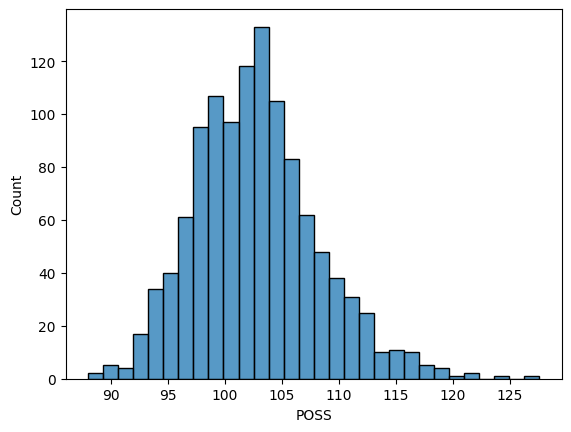

In [26]:
sns.histplot(x='POSS', data=df_m)

<Axes: xlabel='ORtg', ylabel='Count'>

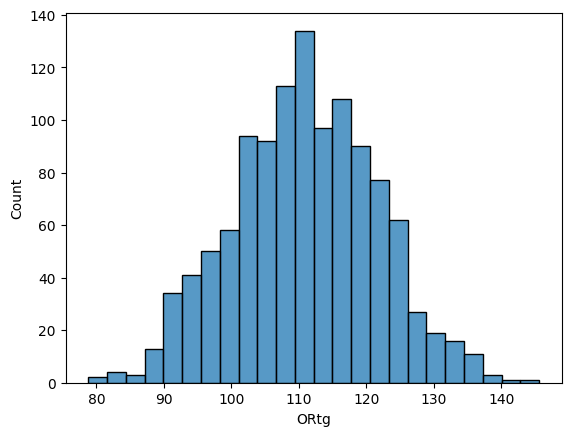

In [27]:
sns.histplot(x='ORtg', data=df_m)

In [33]:
df_m[['ORtg']+hustle_stats].corr()

,ORtg,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,BOX_OUTS
ORtg,1.000000,0.003143,0.027211,-0.027405,-0.083927,-0.016530,0.234670,0.254018,-0.039864,0.020659,-0.013230,-0.004661,0.056359,0.033699,0.043422,0.051044
CONTESTED_SHOTS,0.003143,1.000000,0.767865,0.649138,0.094450,-0.017118,0.049342,0.051781,0.089020,0.117125,0.133718,-0.025669,0.239242,0.168732,0.115522,0.210069
CONTESTED_SHOTS_2PT,0.027211,0.767865,1.000000,0.011157,0.016186,-0.038326,0.019271,0.021846,0.096436,0.087099,0.119473,-0.007799,0.152744,0.116143,0.080618,0.137262
CONTESTED_SHOTS_3PT,-0.027405,0.649138,0.011157,1.000000,0.128209,0.018790,0.054136,0.054886,0.024443,0.079398,0.066858,-0.030807,0.192064,0.125466,0.084593,0.164911
DEFLECTIONS,-0.083927,0.094450,0.016186,0.128209,1.000000,-0.009205,-0.027275,-0.025255,0.039092,0.160573,0.128360,0.069807,0.031909,0.060787,0.047306,0.052565
CHARGES_DRAWN,-0.016530,-0.017118,-0.038326,0.018790,-0.009205,1.000000,-0.013413,-0.011730,0.013074,0.048641,0.039700,-0.013275,0.045310,0.032937,0.010675,0.036570
SCREEN_ASSISTS,0.234670,0.049342,0.019271,0.054136,-0.027275,-0.013413,1.000000,0.981367,-0.070117,-0.006488,-0.050598,0.011708,0.058548,0.040045,-0.023048,0.056683
SCREEN_AST_PTS,0.254018,0.051781,0.021846,0.054886,-0.025255,-0.011730,0.981367,1.000000,-0.066602,-0.010154,-0.050608,0.011407,0.069136,0.053016,-0.014380,0.066324
OFF_LOOSE_BALLS_RECOVERED,-0.039864,0.089020,0.096436,0.024443,0.039092,0.013074,-0.070117,-0.066602,1.000000,0.181932,0.778667,0.114087,0.107374,0.100146,0.116043,0.138476
DEF_LOOSE_BALLS_RECOVERED,0.020659,0.117125,0.087099,0.079398,0.160573,0.048641,-0.006488,-0.010154,0.181932,1.000000,0.758631,-0.025586,0.154836,0.086612,0.060952,0.131287


In [34]:
import statsmodels.api as sm

In [37]:
X_all = df_m[hustle_stats].copy()
X_all1 = sm.add_constant(X_all)
y = df_m['ORtg']

reg_all = sm.OLS(endog=y, exog=X_all1).fit()
print(reg_all.summary())

                            OLS Regression Results                            
Dep. Variable:                   ORtg   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     8.529
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           9.85e-17
Time:                        20:15:14   Log-Likelihood:                -4294.6
No. Observations:                1150   AIC:                             8617.
Df Residuals:                    1136   BIC:                             8688.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [45]:
contested_shots = ['CONTESTED_SHOTS','CONTESTED_SHOTS_2PT', 'CONTESTED_SHOTS_3PT']
others = ['DEFLECTIONS', 'CHARGES_DRAWN']
screen_ast = ['SCREEN_ASSISTS','SCREEN_AST_PTS']
loose_balls = ['OFF_LOOSE_BALLS_RECOVERED','DEF_LOOSE_BALLS_RECOVERED','LOOSE_BALLS_RECOVERED']
boxouts = ['OFF_BOXOUTS','DEF_BOXOUTS','BOX_OUTS','BOX_OUT_PLAYER_TEAM_REBS','BOX_OUT_PLAYER_REBS']


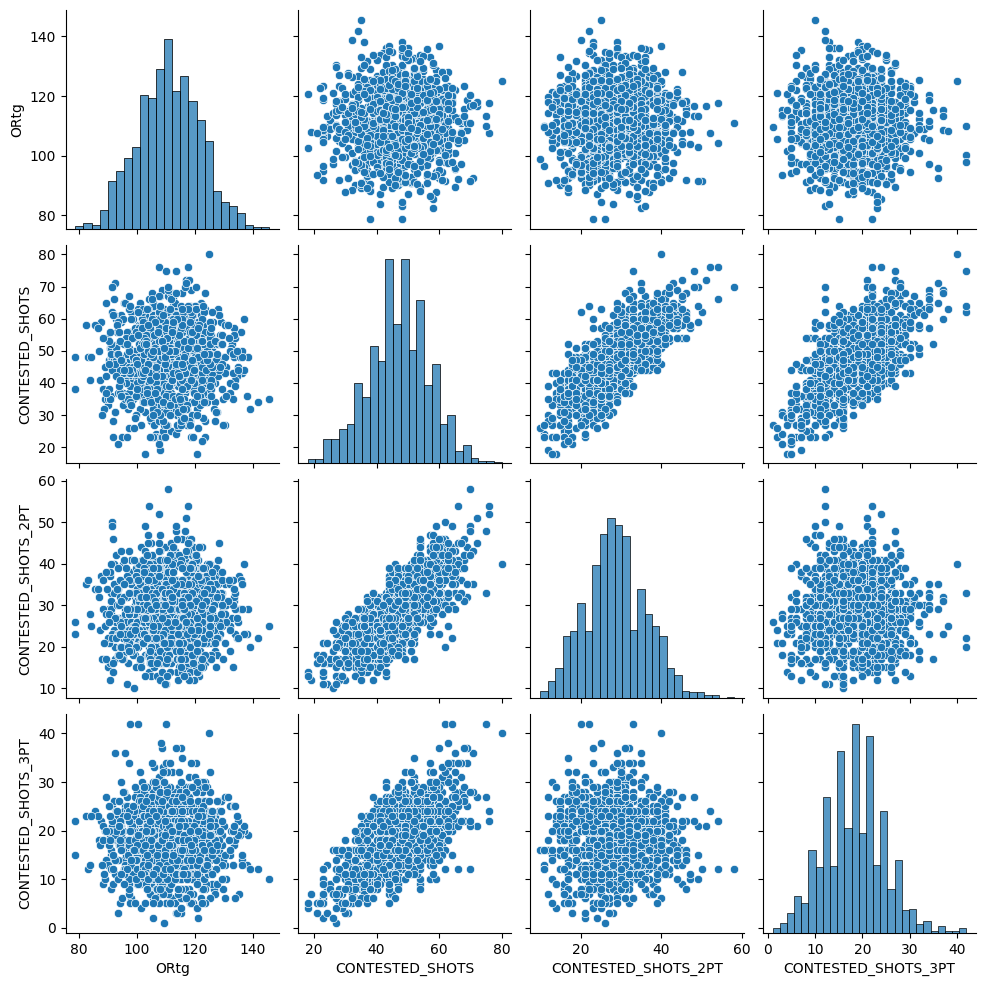

In [49]:
sns.pairplot(df_m[['ORtg']+contested_shots])

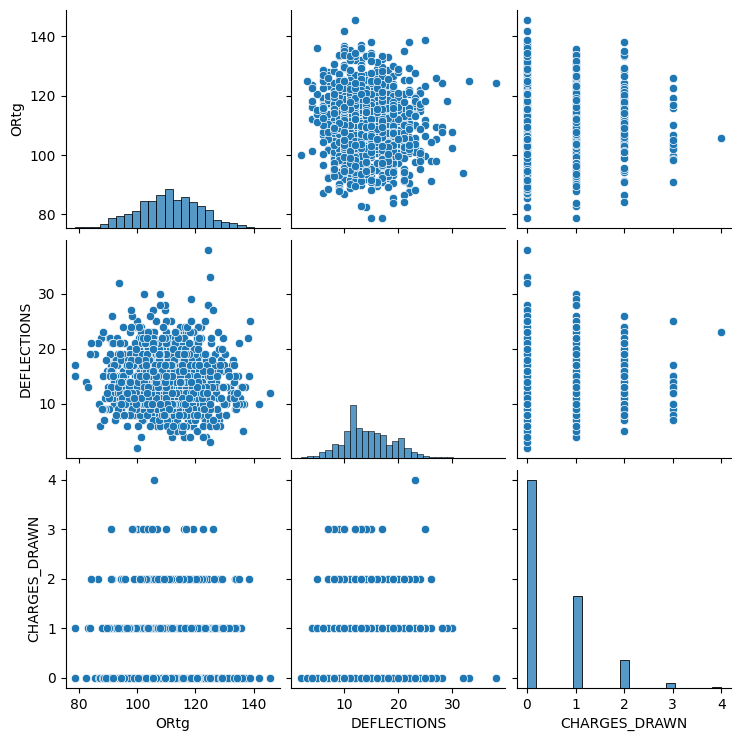

In [41]:
sns.pairplot(df_m[['ORtg']+others])

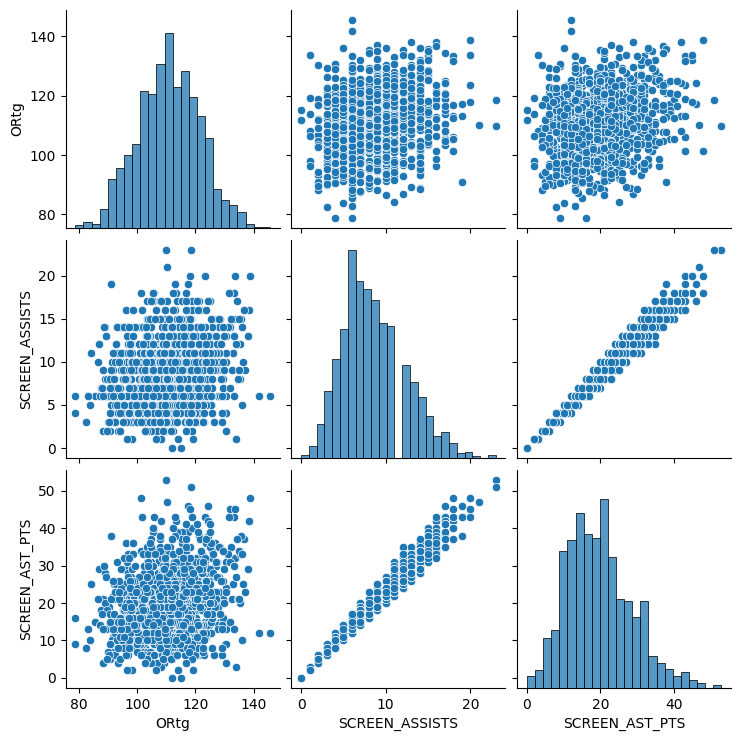

In [42]:
sns.pairplot(df_m[['ORtg']+screen_ast])

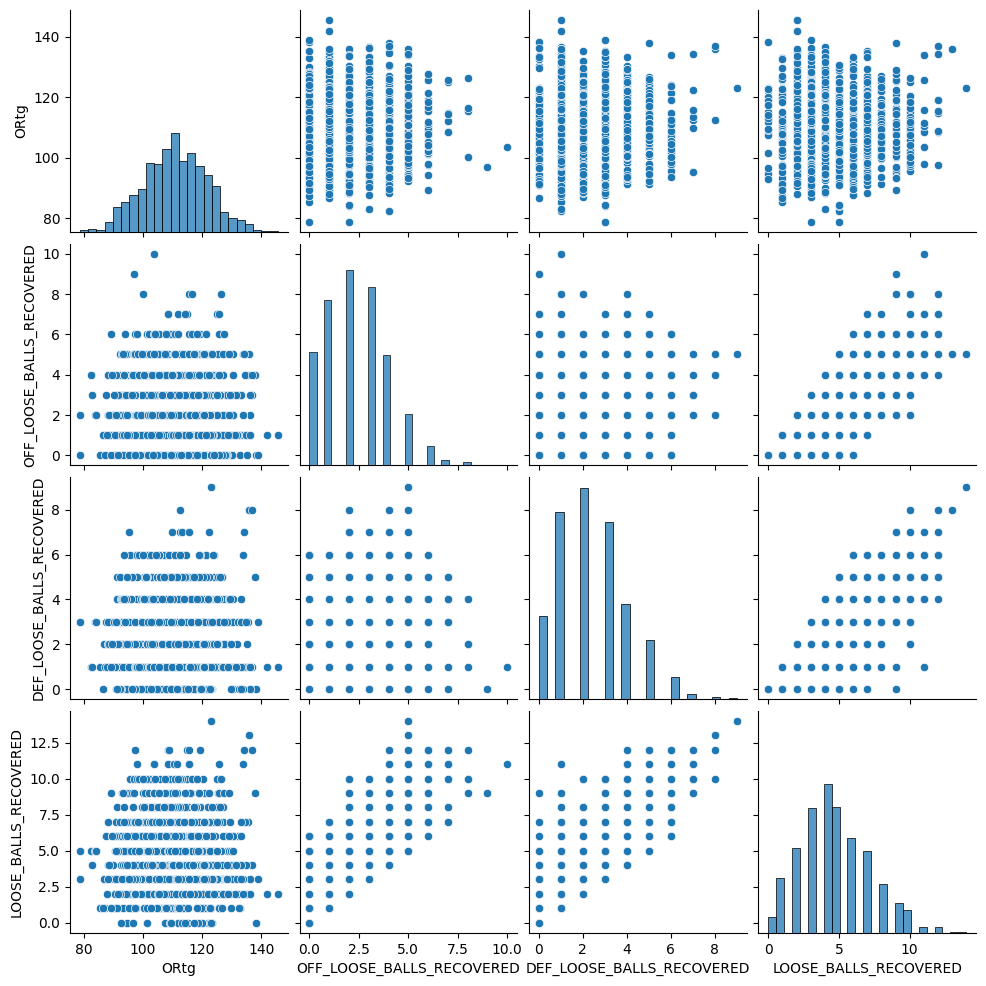

In [43]:
sns.pairplot(df_m[['ORtg']+loose_balls])

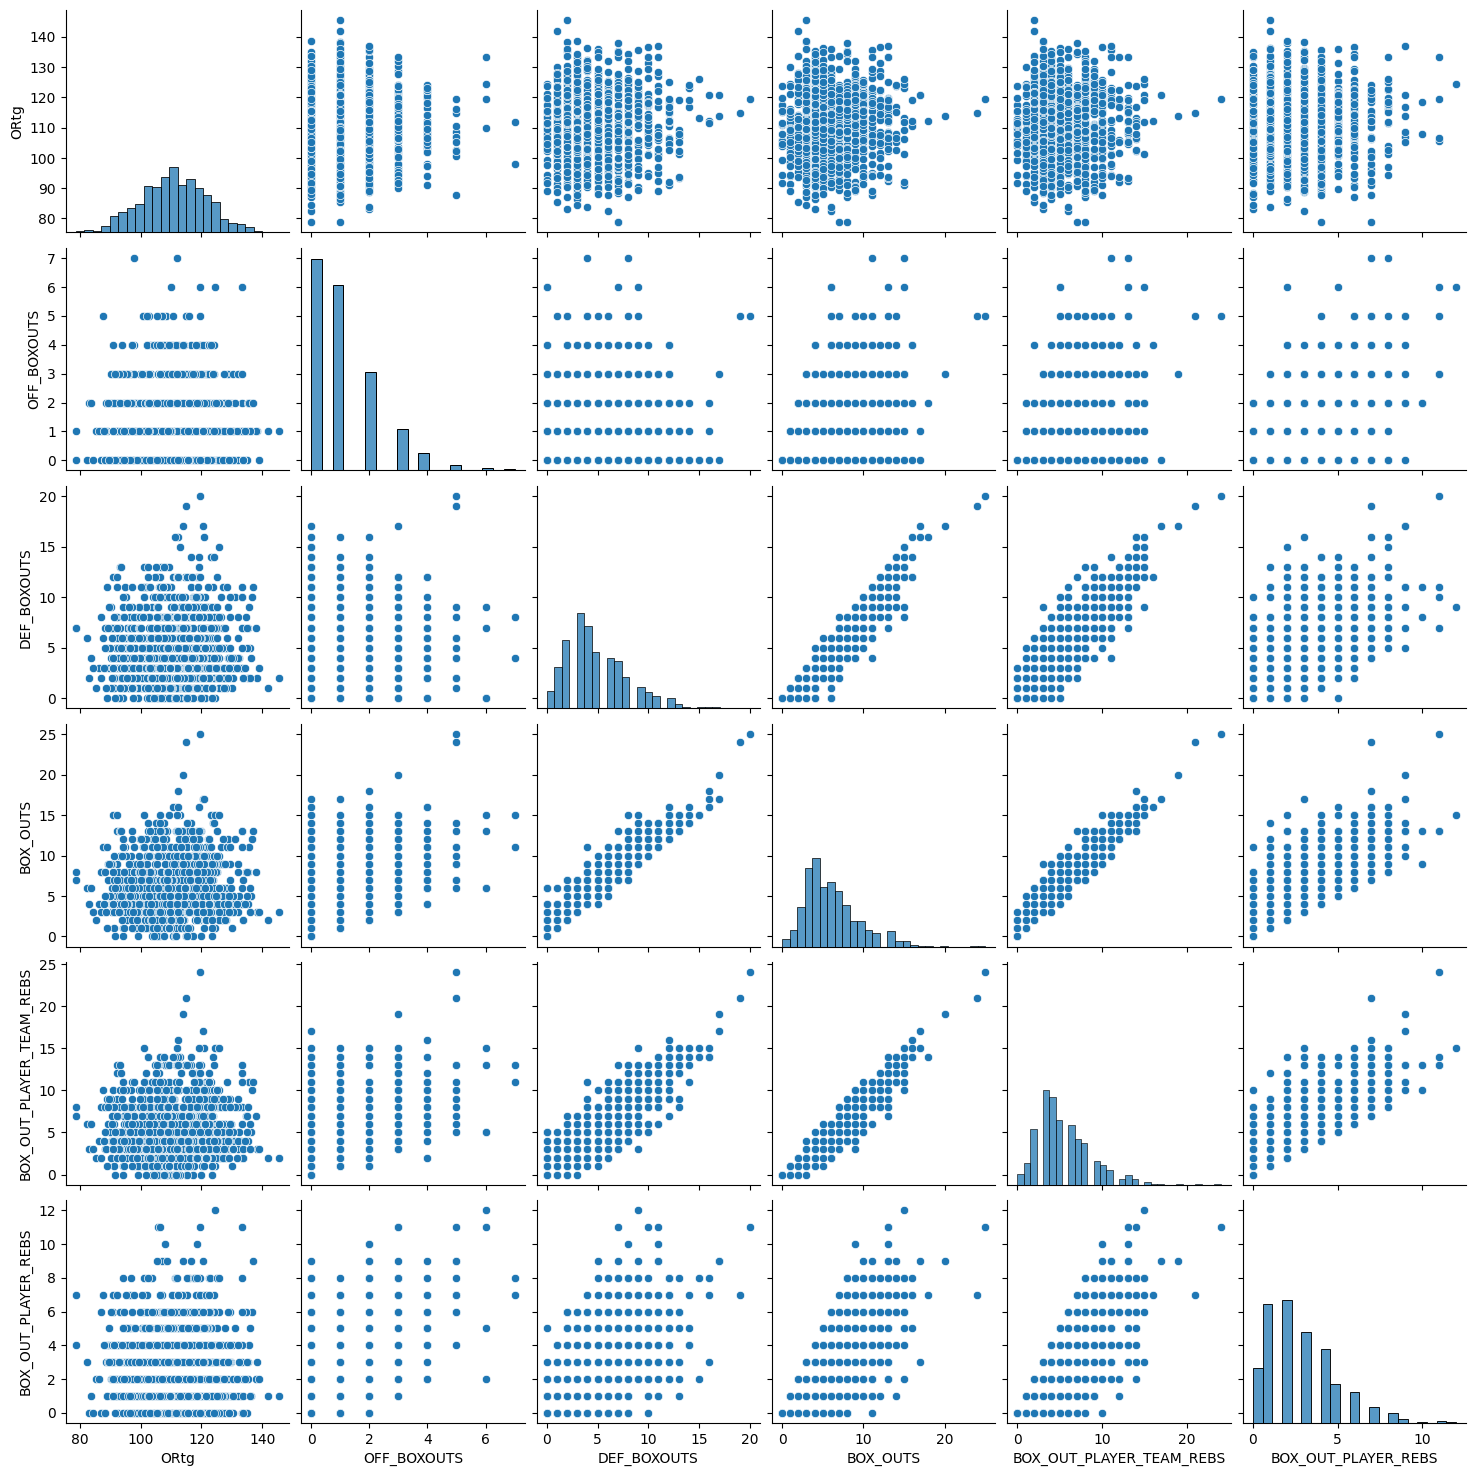

In [46]:
sns.pairplot(df_m[['ORtg']+boxouts])

In [50]:
contested_shots = ['CONTESTED_SHOTS_2PT','CONTESTED_SHOTS_3PT']
screen_ast = ['SCREEN_ASSISTS']
loose_balls = ['OFF_LOOSE_BALLS_RECOVERED','DEF_LOOSE_BALLS_RECOVERED']
boxouts = ['OFF_BOXOUTS','DEF_BOXOUTS']

hustle_features = contested_shots + screen_ast + loose_balls + boxouts + others

In [97]:
def rmse(y_true, y_pred):
    return np.mean((y_true-y_pred)**2)**.5

In [94]:
X = df_m[hustle_features]
X1 = sm.add_constant(X)
reg = sm.OLS(endog=y, exog=X1).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   ORtg   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     9.111
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           2.10e-13
Time:                        21:23:19   Log-Likelihood:                -4308.3
No. Observations:                1150   AIC:                             8637.
Df Residuals:                    1140   BIC:                             8687.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

- The significant metrics are...
    1. Screen Assists
    2. Deflections
    3. Defensive Boxouts

In [98]:
y_hat = reg.predict(X1)
print(f"RMSE: {rmse(y,y_hat): .3f}")

RMSE:  10.251


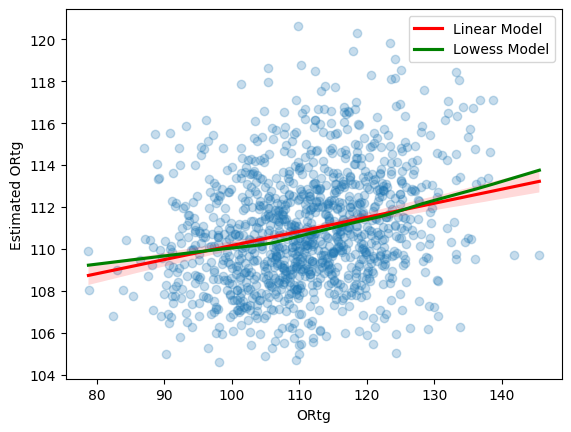

In [78]:
sns.regplot(x=y, y=y_hat, line_kws={'color': 'red', 'label':'Linear Model'}, scatter_kws={'color': 'tab:blue','alpha':.25})
sns.regplot(x=y, y=y_hat, lowess=True, line_kws={'color': 'green', 'label':'Lowess Model'}, scatter_kws={'color':'blue', 'alpha':0})

plt.ylabel('Estimated ORtg')
plt.legend(loc='best')

Text(0.5, 0, 'Predicted ORtg')

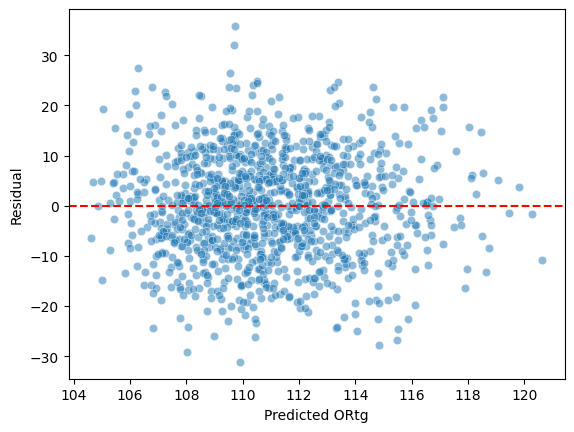

In [73]:
sns.scatterplot(x=y_hat, y=reg.resid, alpha=.5)
plt.axhline(y=0, color='red',linestyle='dashed')
plt.ylabel('Residual')
plt.xlabel('Predicted ORtg')

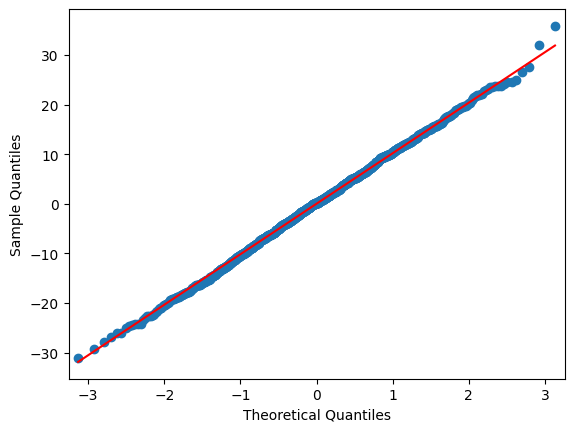

In [74]:
sm.qqplot(reg.resid, line='q')
plt.show()

In [83]:
effort_vec = np.array(reg.params[1:]).reshape((-1,1))
effort_mat = np.array(df_m[hustle_features])
effort_mat.shape, effort_vec.shape

((1150, 9), (9, 1))

In [84]:
df_m['COMPOSITE_EFFORT'] = effort_mat @ effort_vec

<Axes: xlabel='COMPOSITE_EFFORT', ylabel='Count'>

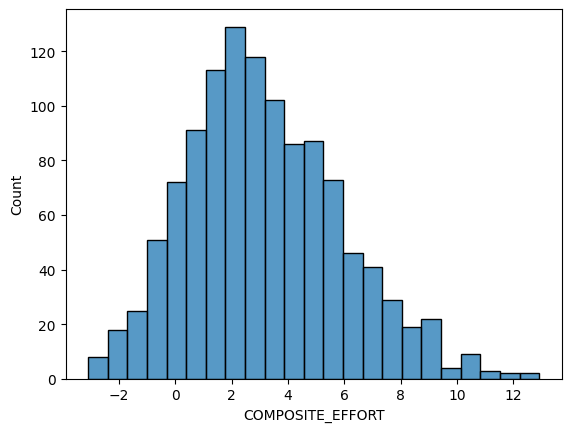

In [86]:
sns.histplot(df_m['COMPOSITE_EFFORT'])

In [87]:
df_m['COMPOSITE_EFFORT'].describe(percentiles=[.001,.01,.05,.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9,.95,.99,.999])

count    1150.000000
mean        3.180697
std         2.750462
min        -3.095375
0.1%       -2.990195
1%         -2.229435
5%         -0.905957
10%        -0.126131
20%         0.862353
25%         1.239067
30%         1.579138
40%         2.230770
50%         2.907799
60%         3.621869
70%         4.496442
75%         4.975440
80%         5.410398
90%         6.933869
95%         8.162271
99%        10.420046
99.9%      12.497143
max        12.912069
Name: COMPOSITE_EFFORT, dtype: float64

<Axes: xlabel='COMPOSITE_EFFORT', ylabel='ORtg'>

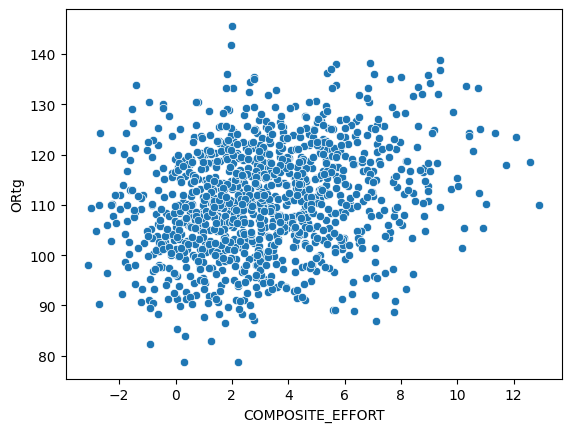

In [89]:
sns.scatterplot(x='COMPOSITE_EFFORT',y='ORtg',data=df_m)

In [92]:
display(df_m[['COMPOSITE_EFFORT','ORtg']].corr(method='pearson'))
display(df_m[['COMPOSITE_EFFORT','ORtg']].corr(method='spearman'))
display(df_m[['COMPOSITE_EFFORT','ORtg']].corr(method='kendall'))

,COMPOSITE_EFFORT,ORtg
COMPOSITE_EFFORT,1.000000,0.259041
ORtg,0.259041,1.000000


,COMPOSITE_EFFORT,ORtg
COMPOSITE_EFFORT,1.000000,0.256455
ORtg,0.256455,1.000000


,COMPOSITE_EFFORT,ORtg
COMPOSITE_EFFORT,1.000000,0.173987
ORtg,0.173987,1.000000


In [95]:
# Regression w/o intercept
reg_no_int = sm.OLS(endog=y, exog=X).fit()
print(reg_no_int.summary())

                                 OLS Regression Results                                
Dep. Variable:                   ORtg   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.966
Method:                 Least Squares   F-statistic:                              3667.
Date:                Tue, 26 Aug 2025   Prob (F-statistic):                        0.00
Time:                        21:24:17   Log-Likelihood:                         -5097.8
No. Observations:                1150   AIC:                                  1.021e+04
Df Residuals:                    1141   BIC:                                  1.026e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

RMSE:  20.367


<Axes: xlabel='None', ylabel='ORtg'>

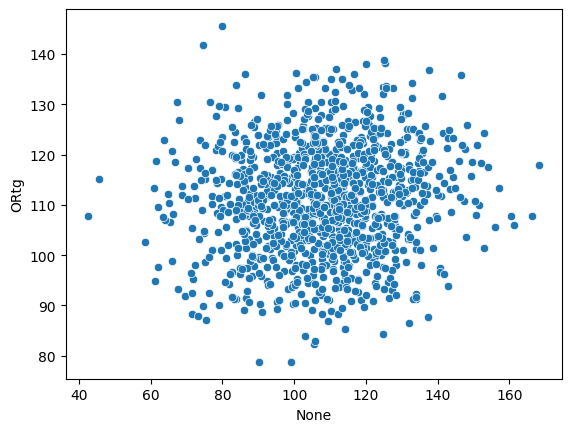

In [99]:
y_hat_no_int = reg_no_int.predict(X)
print(f"RMSE: {rmse(y, y_hat_no_int): .3f}")
sns.scatterplot(x=y_hat_no_int,y=y)

In [114]:
# Four Factors
df_m['eFG%'] = (df_m['FGM']+.5*df_m['FG3M'])/df_m['FGA']
df_m['TOV%'] = df_m['TOV']/df_m['POSS']
df_m['FTRate'] = df_m['FTM']/df_m['FGA']
df_m['EFFORT_x_ScoreDiff'] = df_m['COMPOSITE_EFFORT']*df_m['PLUS_MINUS']
df_m['TIGHT_GAME'] = (np.abs(df_m['PLUS_MINUS'])<5).astype(int)
df_m['EFFORT_x_TIGHT_GAME'] = df_m['COMPOSITE_EFFORT']*df_m['TIGHT_GAME']

In [113]:
df_m['PLUS_MINUS'].describe(percentiles=[.001,.01,.05,.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9,.95,.99,.999])

count    1150.000000
mean        0.000000
std        13.528425
min       -45.000000
0.1%      -42.851000
1%        -32.000000
5%        -21.000000
10%       -17.000000
20%       -11.000000
25%        -9.000000
30%        -7.000000
40%        -4.000000
50%         0.000000
60%         4.000000
70%         7.000000
75%         9.000000
80%        11.000000
90%        17.000000
95%        21.000000
99%        32.000000
99.9%      42.851000
max        45.000000
Name: PLUS_MINUS, dtype: float64

In [115]:
overall_features = ['eFG%','TOV%','FTRate','COMPOSITE_EFFORT', 'TIGHT_GAME','EFFORT_x_TIGHT_GAME']
X_overall = df_m[overall_features]
X1_overall = sm.add_constant(X_overall)
reg_overall = sm.OLS(endog=y, exog=X1_overall).fit()
print(reg_overall.summary())

                            OLS Regression Results                            
Dep. Variable:                   ORtg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     974.8
Date:                Tue, 26 Aug 2025   Prob (F-statistic):               0.00
Time:                        21:54:34   Log-Likelihood:                -3306.8
No. Observations:                1150   AIC:                             6628.
Df Residuals:                    1143   BIC:                             6663.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  44.1596    

In [105]:
df_m[overall_features].head(10)

,eFG%,TOV%,FTRate,COMPOSITE_EFFORT
0,0.634146,0.110753,0.268293,2.961322
1,0.581250,0.136826,0.300000,3.771592
2,0.535354,0.155012,0.171717,8.031356
3,0.478723,0.186441,0.202128,-1.904690
4,0.439394,0.137312,0.151515,-1.191920
5,0.512048,0.206044,0.204819,0.631670
6,0.558442,0.173257,0.246753,3.594145
7,0.558824,0.151860,0.152941,2.773876
8,0.538889,0.085260,0.222222,6.646673
9,0.537500,0.183895,0.275000,3.027517


In [106]:
df_m[overall_features].corr()

,eFG%,TOV%,FTRate,COMPOSITE_EFFORT
eFG%,1.000000,0.137814,-0.019704,0.235453
TOV%,0.137814,1.000000,0.060712,-0.139549
FTRate,-0.019704,0.060712,1.000000,-0.076056
COMPOSITE_EFFORT,0.235453,-0.139549,-0.076056,1.000000


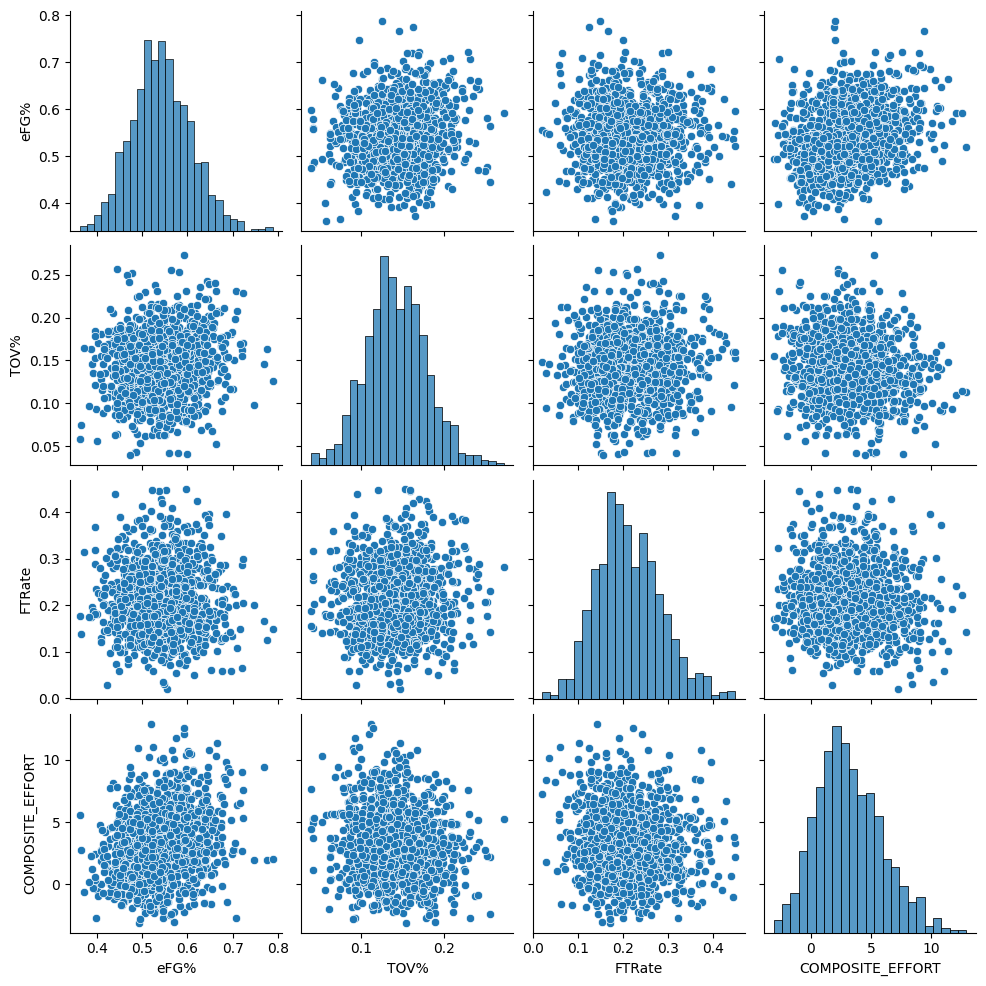

In [107]:
sns.pairplot(df_m[overall_features])

In [118]:
y_efg = df_m['eFG%']
X_efg = df_m['COMPOSITE_EFFORT']
X1_efg = sm.add_constant(X_efg)
reg_efg = sm.OLS(endog=y_efg, exog=X1_efg).fit()
print(reg_efg.summary())

                            OLS Regression Results                            
Dep. Variable:                   eFG%   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     67.38
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           5.97e-16
Time:                        22:02:42   Log-Likelihood:                 1540.2
No. Observations:                1150   AIC:                            -3076.
Df Residuals:                    1148   BIC:                            -3066.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5246      0.003  